# Invasive Ductal Carcinoma Predictive Model

## Introduction

The goal of our project is to design and optimize a Convolutional Neural Network that uses modern architectural patterns and has the capacity to accurately detect the presence of Invasive Ductal Carcinoma in breast histopathology images. We are interested in this project idea because automating this process using deep learning can assist pathologists, reduce diagnostic time, and improve patient outcomes significantly.


In [ ]:
import os
import numpy as np
import cv2
import shutil
import random
from sklearn.model_selection import train_test_split
from kagglehub import dataset_download
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, DepthwiseConv2D, Add, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import pandas as pd
from skimage.io import imread

## Preprocessing

Utility Functions

In [ ]:
def load_images(image_paths):
    X = []
    y = []
    for path in image_paths:
        label = int(path.split("/")[-2])
        image = cv2.imread(path, cv2.IMREAD_COLOR)  # Load RGB image
        image = cv2.resize(image, (50, 50))
        X.append(image)
        y.append(label)
    return np.array(X), np.array(y)

def count_images_in_dir(data, labels):
    count = {"0": 0, "1": 0}
    for label in labels:
        count[str(label)] += 1
    return count

def add_counts(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha="center", va="bottom")
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

The first thing we must do is download our dataset and place the images and labels into lists. Our dataset is downloadable from Kaggle using kagglehub. Using some clever file path code we can successfuly sort the dataset into a usable format into X and y.

In [ ]:
original_path = dataset_download("paultimothymooney/breast-histopathology-images")
print("Dataset Path:", original_path)

if os.path.exists(original_path):
    print(f"Directory exists: {original_path}")
    print("Subdirectories:", os.listdir(original_path))
else:
    print("Dataset not found!")

X = []
y = []

for directory in os.listdir(original_path):
    dir_path = os.path.join(original_path, directory)
    if os.path.isdir(dir_path):
        for label in ["0", "1"]:
            class_path = os.path.join(dir_path, label)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    X.append(os.path.join(class_path, img))
                    y.append(label)

100%|██████████| 3.10G/3.10G [00:20<00:00, 166MB/s]

Extracting files...


Dataset Path: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1
Directory exists: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1
Subdirectories: ['10259', '12884', '15471', '9255', '12895', '10276', '16555', '9175', '13692', '9347', '13459', '12880', '13019', '8955', '12901', '16085', '10272', '15516', '8865', '9226', '15840', '12893', '10295', '9081', '9382', '14081', '14189', '16569', '8951', '10308', '10279', '9044', '12868', '8959', '12908', '14156', '13461', '9022', '12750', '12906', '9261', '9123', '10282', '16533', '9260', '10274', '12822', '10305', 'IDC_regular_ps50_idx5', '16165', '14191', '12954', '8864', '13688', '12910', '15515', '16552', '12934', '13020', '12748', '8950', '13402', '14078', '8914', '13025', '13691', '10306', '9083', '13458', '15513', '8974', '9324', '12930', '9037', '10286', '10299', '12875', '12896', '9259', '12817', '12241', '12820', '9124', '13666', '12886', '13617', '1421

In [ ]:
X = np.array(X)
y = np.array(y).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Now we have to convert the images into their size and rgb data to allow our convolutional network to function properly.

In [ ]:
# Warning: This may take a few minutes
X_train, y_train = load_images(X_train)
X_test, y_test = load_images(X_test)

Sanity Checks to see if the images were processed correctly.

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_test.shape)

X_train shape: (222019, 50, 50, 3)
y_train shape: (222019,)
X_test shape: (55505, 50, 50, 3)
y_train shape: (55505,)


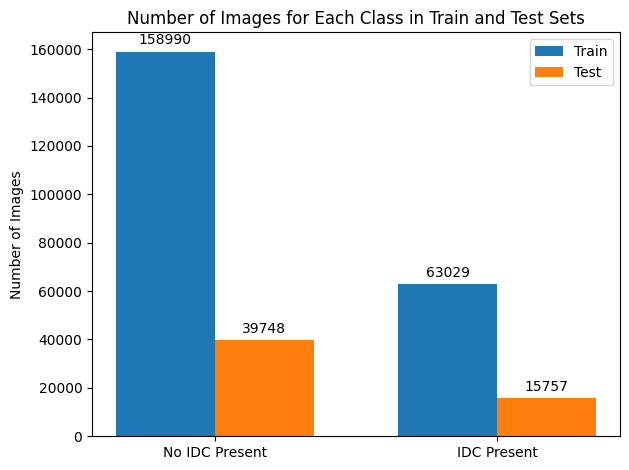

In [ ]:
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

labels = ['No IDC Present', 'IDC Present']
train_counts = train_counts[:2]
test_counts = test_counts[:2]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

ax.set_ylabel('Number of Images')
ax.set_title('Number of Images for Each Class in Train and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


## Data Exploration

Let's see what are images actually look like.

In [ ]:
df = pd.DataFrame({"path": X, "target": y})

pos_indices = df[df.target == 1].index
neg_indices = df[df.target == 0].index

pos_samples = np.random.choice(pos_indices, size=40, replace=False)
neg_samples = np.random.choice(neg_indices, size=40, replace=False)

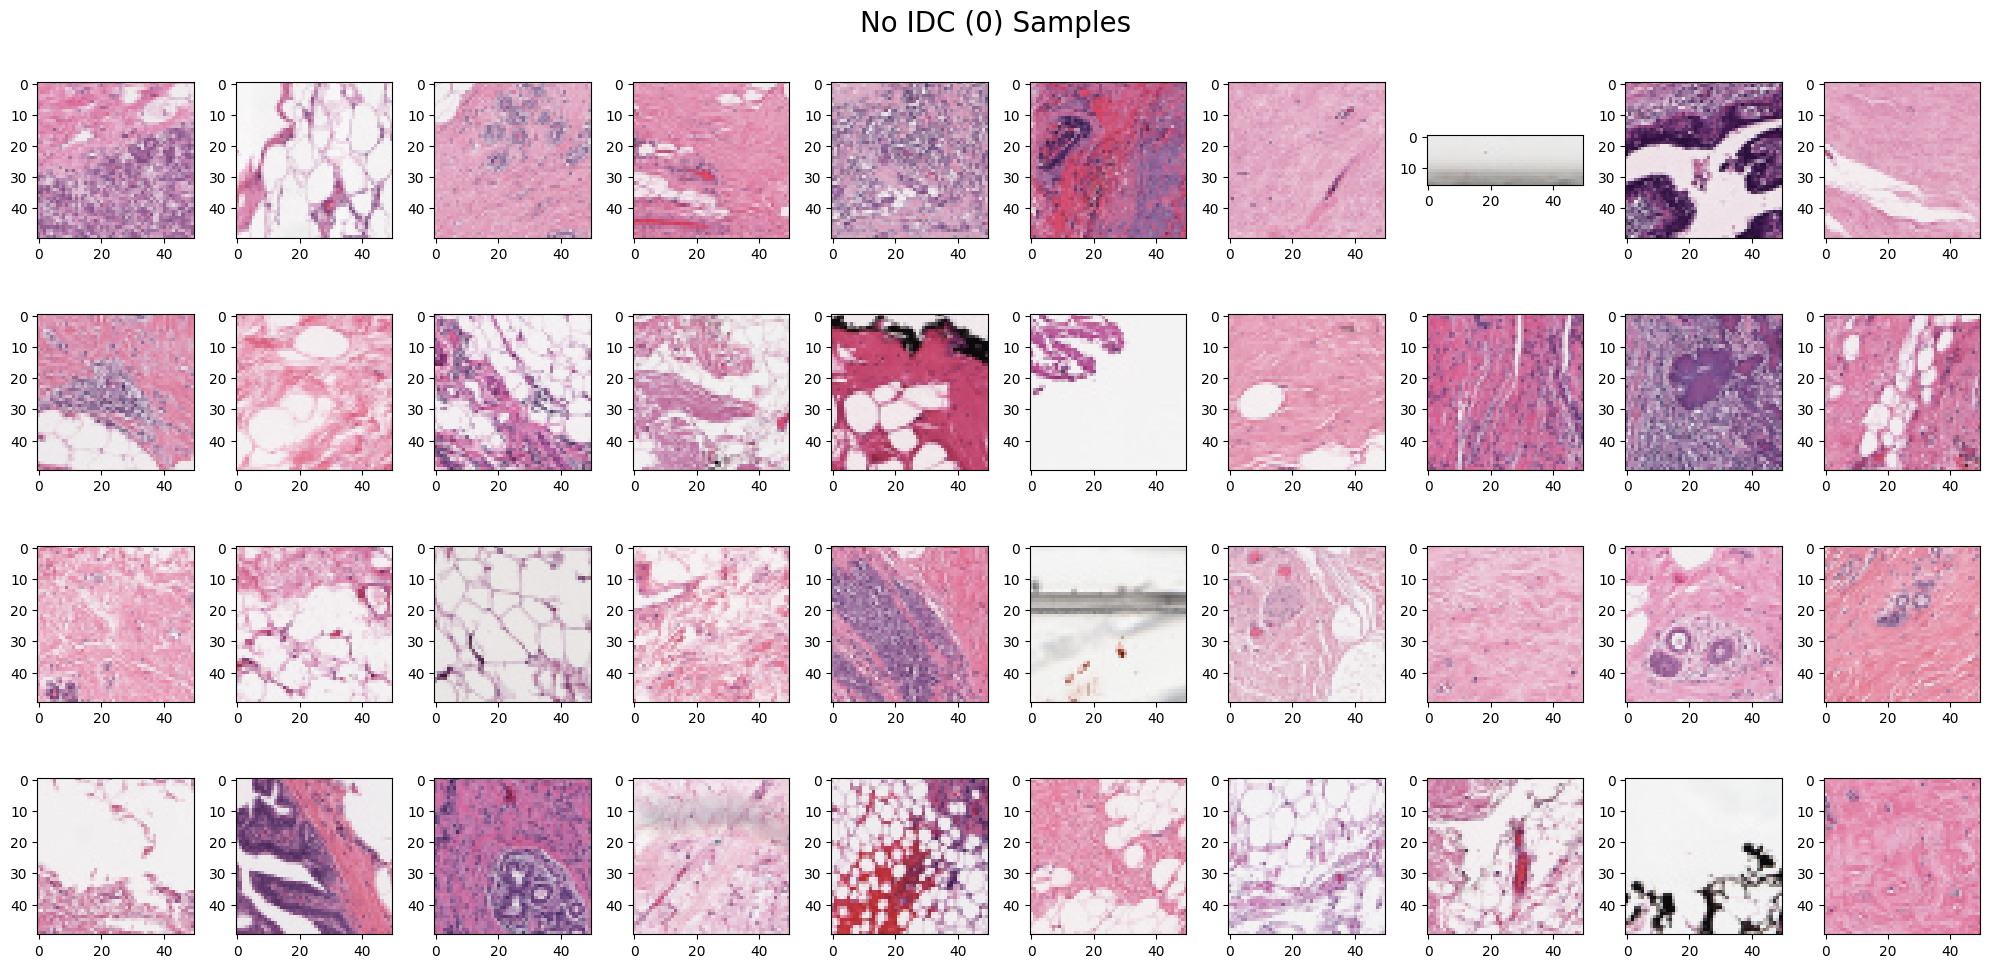

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(20, 10))
fig.suptitle("No IDC (0) Samples", fontsize=20)

for i in range(4):
    for j in range(10):
        idx = neg_samples[j + 10*i]
        image = imread(df.loc[idx, "path"])
        ax[i, j].imshow(image)
        # ax[i, j].axis('off')

plt.tight_layout()
plt.show()


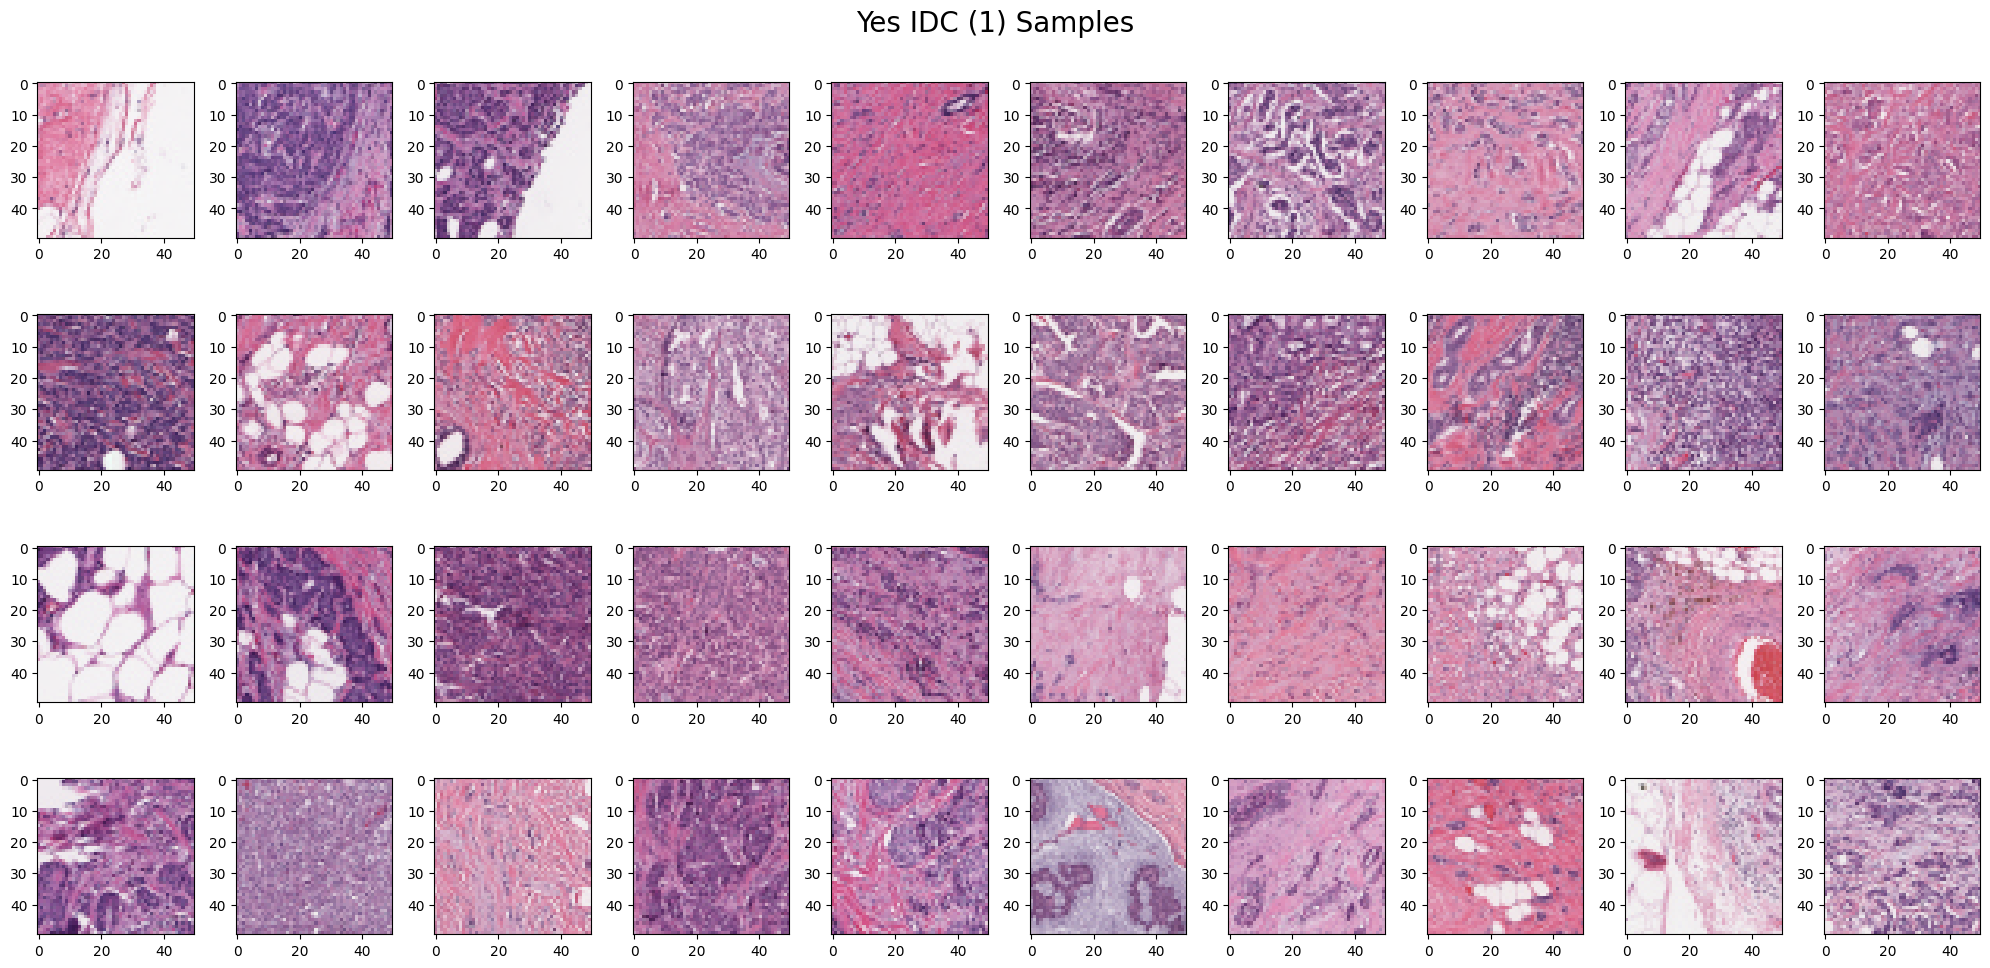

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(20, 10))
fig.suptitle("Yes IDC (1) Samples", fontsize=20)

for i in range(4):
    for j in range(10):
        idx = pos_samples[j + 10*i]
        image = imread(df.loc[idx, "path"])
        ax[i, j].imshow(image)
        # ax[i, j].axis('off')

plt.tight_layout()
plt.show()

It's fascinating to see these images. At first glance it is possible to begin to distinguish the positive class from the negative. The positive class has much deeper purples and feature larger structures when compared to the negative class.

## Making Our Model

In order to find the best model that we can, we decided to implement a grid search. Due to resource limitations we weren't able to do a large search, but were able to design a model that is able to accept a lot of parameters to try.

In [ ]:
def scores_to_dataframe(scores):
    """ Return hyperparameters and scores in a data frame. """

    params_list, acc_list = scores

    params = pd.DataFrame(params_list)
    accs = pd.Series(acc_list)
    scores_df = pd.concat([params, accs], axis=1)

    scores_df.rename(columns={0: 'accuracy'}, inplace=True)

    return scores_df

In [ ]:
default_params = {
    'conv_layers': [32],
    'dense_layers': [64],
    'conv_layer_type': 'standard',
    'use_stacked': False,
    'activation_function': 'relu',
    'optimizers': 'adam'
}

In [ ]:
def evaluate_params(params, verbose=1):
    pars = default_params.copy()
    pars.update(params)

    conv_layers = pars['conv_layers']
    dense_layers = pars['dense_layers']
    conv_layer_type = pars['conv_layer_type']
    use_stacked = pars['use_stacked']
    activation_function = pars['activation_function']

    optimizer_mapping = {
        'adam': keras.optimizers.Adam(),
        'nadam': keras.optimizers.Nadam()
    }

    optimizer_class = optimizer_mapping[pars['optimizers']]

    K.clear_session()

    model = get_model(conv_layers, dense_layers, conv_layer_type, use_stacked, activation_function)

    model.compile(
        optimizer=optimizer_class,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(X_train, y_train, epochs=10, callbacks=[early_stopping], batch_size=32,
                        validation_split=0.2, verbose=verbose)
    highest_acc = max(history.history['val_accuracy'])

    return pars, highest_acc, history

In [ ]:
def grid_search(param_grid, verbose=1):

    params_list = []
    acc_list = []
    for params in ParameterGrid(param_grid):
        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

In [ ]:
def get_model(conv_layers, dense_layers, conv_layer_type, use_stacked, activation_function):
    inputs = Input(shape=(X_train.shape[1:]))
    x = inputs

    if not use_stacked:
        for n in conv_layers:
            if conv_layer_type == 'standard':
                residual = x
                x = Conv2D(n, 3, use_bias=False, padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation(activation_function)(x)
                x = MaxPooling2D(2)(x)

                residual = Conv2D(n, 1, use_bias=False, padding='same')(residual)
                residual = MaxPooling2D(2)(residual)
                x = Add()([x, residual])

            elif conv_layer_type == 'depthwise':
                residual = x
                x = DepthwiseConv2D(3, use_bias=False, padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation(activation_function)(x)
                x = MaxPooling2D(2)(x)

                residual = MaxPooling2D(2)(residual)
                x = Add()([x, residual])

            elif conv_layer_type == 'strided':
                residual = x
                x = Conv2D(n, 3, strides=2, use_bias=False, padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation(activation_function)(x)

                residual = Conv2D(n, 1, strides=2, use_bias=False, padding='same')(residual)
                x = Add()([x, residual])

    else:
        residual = x
        for n in conv_layers:
            if conv_layer_type == 'standard':
                x = Conv2D(n, 3, padding='same')(x)
            elif conv_layer_type == 'depthwise':
                x = DepthwiseConv2D(3, padding='same')(x)
            elif conv_layer_type == 'strided':
                x = Conv2D(n, 3, strides=2, padding='same')(x)

        x = BatchNormalization()(x)
        x = Activation(activation_function)(x)
        if conv_layer_type != 'strided':
            x = MaxPooling2D(2)(x)

        if conv_layer_type == 'standard':
            residual = Conv2D(conv_layers[-1], 1, padding='same')(residual)
            residual = MaxPooling2D(2)(residual)
        elif conv_layer_type == 'depthwise':
            residual = MaxPooling2D(2)(residual)
        elif conv_layer_type == 'strided':
            for n in conv_layers:
                residual = Conv2D(n, 1, strides=2, padding='same')(residual)

        x = Add()([x, residual])

    x = Flatten()(x)

    for n in dense_layers:
        x = Dense(n)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_function)(x)
        x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    return model


In [ ]:
# Sidenote: We had originally ran a larger grid search but after some resource limitations we limited it to only search in meaningful areas
parameters_grid = {
    'conv_layers': [[32, 16, 64], [64, 32, 16], [16, 32, 64, 64]],
    'dense_layers': [[64]],
    'conv_layer_type': ['standard', 'depthwise', 'strided'],
    'use_stacked': [False],
    'activation_function': ['relu'],
    'optimizers': ['adam']
}

results = grid_search(parameters_grid)

params: {'activation_function': 'relu', 'conv_layer_type': 'standard', 'conv_layers': [32], 'dense_layers': [64], 'optimizers': 'adam', 'use_stacked': True}


I0000 00:00:1734225473.383228   27306 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-12-14 17:17:59.370109: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1332112500 exceeds 10% of free system memory.
2024-12-14 17:18:00.573607: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1332112500 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1734225482.233070   27442 service.cc:148] XLA service 0x7fc66c00db80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734225482.233591   27442 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-14 17:18:02.285339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734225482.488982   27442 cuda_dnn.cc:529] Loaded cuDNN version 90300


  80/5551 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7274 - loss: 0.7121

I0000 00:00:1734225484.221822   27442 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5551/5551 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8191 - loss: 0.4186

2024-12-14 17:18:17.460209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333030000 exceeds 10% of free system memory.
2024-12-14 17:18:17.641324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333030000 exceeds 10% of free system memory.


5551/5551 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8191 - loss: 0.4186 - val_accuracy: 0.7503 - val_loss: 0.7864
Epoch 2/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8559 - loss: 0.3425 - val_accuracy: 0.7179 - val_loss: 0.8449
Epoch 3/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8590 - loss: 0.3331 - val_accuracy: 0.7185 - val_loss: 1.1904
Epoch 4/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8625 - loss: 0.3277 - val_accuracy: 0.7363 - val_loss: 0.7803
Epoch 5/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8654 - loss: 0.3225 - val_accuracy: 0.3155 - val_loss: 3.1608
Epoch 6/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8666 - loss: 0.3186 - val_accuracy: 0.8075 - val_loss: 0.4750
Epoch 7/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8685 - loss: 0.3172 - val_accuracy: 0.8411 - val_loss: 0.3652
Epoch 8/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8710 - loss: 0.3104 - val

2024-12-14 17:20:25.242850: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1332112500 exceeds 10% of free system memory.


Epoch 1/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8261 - loss: 0.4021 - val_accuracy: 0.8016 - val_loss: 0.4623
Epoch 2/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8566 - loss: 0.3397 - val_accuracy: 0.7222 - val_loss: 0.7464
Epoch 3/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8581 - loss: 0.3370 - val_accuracy: 0.8153 - val_loss: 0.4195
Epoch 4/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8624 - loss: 0.3283 - val_accuracy: 0.7374 - val_loss: 0.9669
Epoch 5/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8618 - loss: 0.3277 - val_accuracy: 0.7826 - val_loss: 0.5810
Epoch 6/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8670 - loss: 0.3192 - val_accuracy: 0.8534 - val_loss: 0.3814
Epoch 7/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8649 - loss: 0.3193 - val_accuracy: 0.8554 - val_loss: 0.3416
Epoch 8/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8696 - loss: 0

In [ ]:
scores_df = scores_to_dataframe(results)
scores_df.sort_values(by='accuracy', ascending=False, inplace=True)
print(scores_df[:5])

         conv_layers dense_layers conv_layer_type  use_stacked  \
7   [16, 32, 64, 64]         [64]        standard        False   
3       [32, 16, 64]         [64]        standard        False   
23  [16, 32, 64, 64]         [64]         strided        False   
6   [16, 32, 64, 64]         [64]        standard         True   
1               [32]         [64]        standard        False   

   activation_function optimizers  accuracy  
7                 relu       adam  0.879898  
3                 relu       adam  0.876408  
23                relu       adam  0.867489  
6                 relu       adam  0.859315  
1                 relu       adam  0.855441  


According to our search that we conducted, it seems that a standard convolutional neural network seems to work pretty well. Interestingly enough it looks like a larger amount of convolutional layers improves performance. We would like to explore this further but due to resource limitations larger models are out of our reach. Knowing this however, let's attempt to take this best model to it's limits.

In [ ]:
def best_model():
    inputs = Input(shape=(X_train.shape[1:]))
    x = inputs

    for n in [32]:
        x = Conv2D(n, 3, use_bias=False, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(2)(x)

    x = Flatten()(x)

    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    return model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         640,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641,185 (2.45 MB)

 Trainable params: 641,057 (2.45 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8396 - loss: 0.3699 - val_accuracy: 0.8422 - val_loss: 0.3716 - learning_rate: 0.0100
Epoch 2/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8626 - loss: 0.3226 - val_accuracy: 0.8604 - val_loss: 0.3356 - learning_rate: 0.0100
Epoch 3/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8683 - loss: 0.3117 - val_accuracy: 0.3116 - val_loss: 2.5484 - learning_rate: 0.0100
Epoch 4/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8744 - loss: 0.2982 - val_accuracy: 0.8349 - val_loss: 0.3768 - learning_rate: 0.0100
Epoch 5/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8807 - loss: 0.2858 - val_accuracy: 0.3746 - val_loss: 1.9982 - learning_rate: 0.0100
Epoch 6/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8924 - loss: 0.2628 - val_accuracy: 0.8495 - val_loss: 0.3621 - learning_rate: 0.0050
Epoch 7/100
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accura

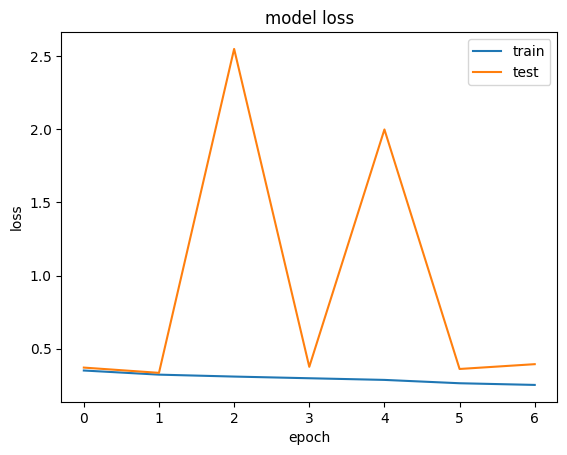

In [ ]:
K.clear_session()
best_model = best_model()
best_model.compile(
        optimizer=keras.optimizers.SGD(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

best_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

best_history = best_model.fit(
    X_train, y_train,
    callbacks=[early_stopping, lr_scheduler],
    epochs = 100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plot_metric(best_history)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8599 - loss: 0.3383
Test Accuracy: 0.8602


All in all the model seems to have underperformed expectations but the loss curves do shed some light on what is going wrong. It seems to be greatly overfitting to the training data. I had asssumed a deeper model would have worked great based on the results from the grid search but it seems that maybe that was a naive result. Since we have almost 300,000 images I did think we had more than enough data.

Regardless a test accuracy of 0.88 is still very efficient. Let's try to analyze how this model actually works. Using ChatGPT we were able to display some heat maps that show what the model is looking at.

## Visualizing Our Model

Grad-CAM highlights the specific regions of the image (e.g., tissue areas) that contribute most to the model's prediction.

In [ ]:
def grad_cam(model, img_array, last_conv_layer_name="conv2d"):
    """
    Generate Grad-CAM heatmap for binary classification.
    """
    # Create a model mapping input to last conv layer and predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    heatmap_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Forward pass and compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img_array)
        loss = predictions[:, 0]  # Single output for binary classification

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # Remove batch dimension

    # Weight the feature maps
    weighted_conv_outputs = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # Generate the heatmap
    heatmap = tf.maximum(weighted_conv_outputs, 0)  # ReLU: remove negative values
    heatmap /= (tf.reduce_max(heatmap) + 1e-10)  # Add epsilon to avoid division by zero
    return heatmap.numpy()


# Function to overlay heatmap on the original image
def overlay_heatmap(original_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay the Grad-CAM heatmap on the original image.
    """
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

Saliency maps provide fine-grained pixel-level importance for the prediction. Unlike Grad-CAM, saliency maps are computed directly from the input image and gradients, making them more precise but harder to interpret intuitively.

In [ ]:
def saliency_map(model, img_array):
    """
    Generate a saliency map for a given image for binary classification.
    """
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)  # Watch the input image
        predictions = model(img_tensor)
        loss = predictions[:, 0]  # Single output for binary classification

    # Compute gradients of the loss w.r.t. the input image
    grads = tape.gradient(loss, img_tensor)
    grads = tf.reduce_mean(grads, axis=-1).numpy()[0]  # Convert to 2D array

    # Normalize to [0, 1]
    saliency = np.maximum(grads, 0)  # ReLU
    saliency /= np.max(saliency) + 1e-10  # Avoid division by zero
    return saliency

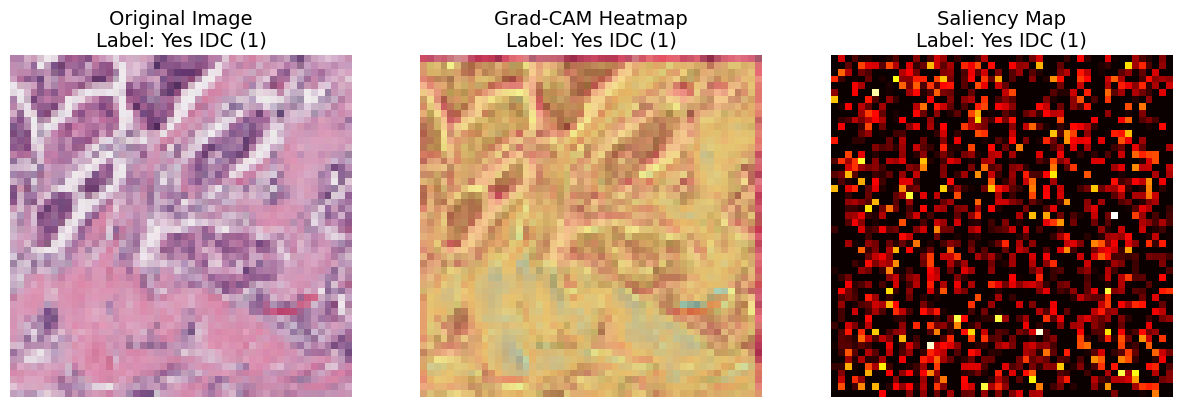

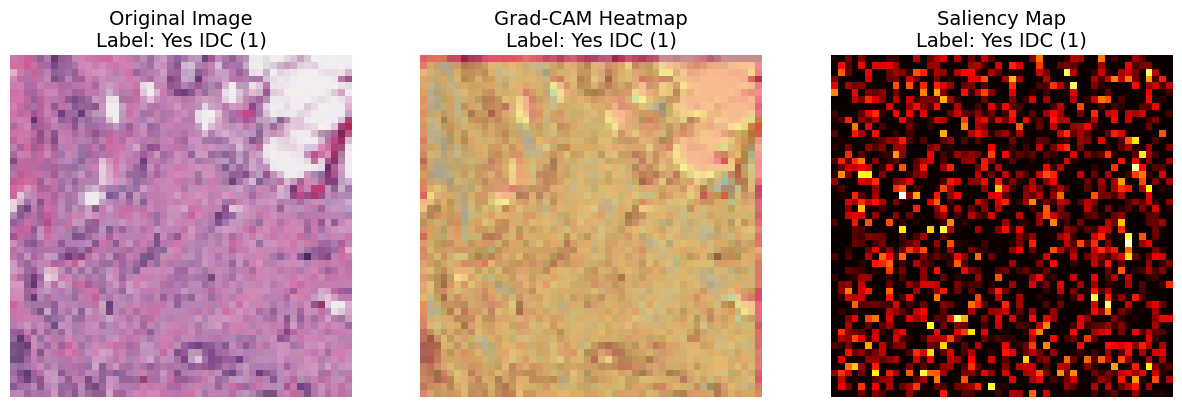

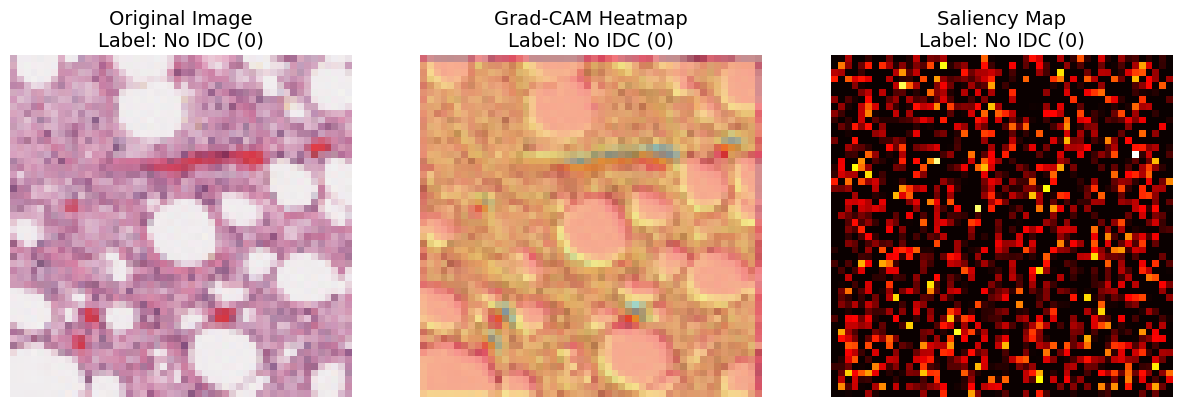

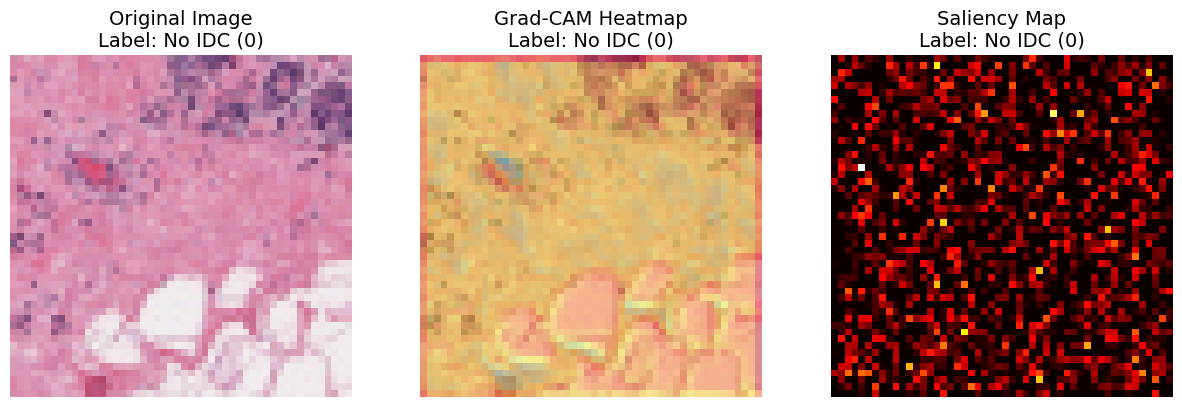

In [ ]:
def display_grad_cam_and_saliency(model, df, last_conv_layer_name="conv2d"):
    """
    Display Grad-CAM and Saliency maps with labels for random images.
    """
    pos_indices = df[df["target"] == 1].index
    neg_indices = df[df["target"] == 0].index

    # Randomly sample 2 images for Yes IDC (1) and 2 images for No IDC (0)
    selected_indices = list(random.sample(list(pos_indices), 2)) + list(random.sample(list(neg_indices), 2))

    for idx in selected_indices:
        image_path = df.loc[idx, "path"]
        label = df.loc[idx, "target"]  # Get the correct label for the image

        # Load and preprocess the image
        original_img = cv2.imread(image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(original_img, (50, 50)) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Generate Grad-CAM
        heatmap = grad_cam(model, img_array, last_conv_layer_name)
        overlay = overlay_heatmap(original_img, heatmap)

        # Generate Saliency Map
        saliency = saliency_map(model, img_array)

        # Define label text
        label_text = "Yes IDC (1)" if label == 1 else "No IDC (0)"

        # Plot Results
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        plt.title(f"Original Image\nLabel: {label_text}", fontsize=14)
        plt.imshow(original_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(f"Grad-CAM Heatmap\nLabel: {label_text}", fontsize=14)
        plt.imshow(overlay)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title(f"Saliency Map\nLabel: {label_text}", fontsize=14)
        saliency_resized = cv2.resize(saliency, (original_img.shape[1], original_img.shape[0]))
        plt.imshow(saliency_resized, cmap="hot")
        plt.axis("off")

        plt.show()



df = pd.DataFrame({"path": X, "target": y})
display_grad_cam_and_saliency(best_model, df, last_conv_layer_name="conv2d")

It's incredible to be able to visualize what our model is looking at to classify these images. The Grad-CAM heatmap in particular is very intriguing. We can see the blue areas that the model disregards as well as the red parts that it uses as the biggest indicator of if the image contains IDC!

The saliency map is a little harder to understand but it's basically showing which pixels that strongly influenced the prediction. For IDC detection, these bright areas might represent edges, shapes, or textures the model associates with cancerous patterns.

# Conclusion

Throughout the course of this project we were able to apply much of the knowledge we have learned in CST 463. From setting up image data to designing convolutional neural networks this project allowed us to get a better grasp of the material.

While loading the data, we noticed a significant difference between the amount of (+IDC) and (-IDC) images, which could cause a problem. Although, when testing it with a simple model, we realized that data balancing wasn't necessary. It was surprising to see that even with a simple model, the accuracy was passable. That's when we decided to perform a grid search.

The grid search we wrote, while limited by the computational resources available to us, was one of the highights. The model was written in such a way that it can seamlessly accept a variety of different parameter combinations and compile and train all of them in an efficient manner. While in the end our search did not produce a model that could get above 90% test accuracy, we have confidence that an expanded search could find one that can accurately classify these images with great precision.

Lastly, we wanted to actually understand how the model was making predictions, so we implemented different visualization methods to facilitate this. We were able to generate maps of what the model highlighted as important and unimportant. This was very helpful, as it confirmed that our model identifies certain regions in the image as relevant for prediction.

